In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 10})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import (
    matrix_normalization,
    convert_states_str2int,
    normalize_state,
    normalize_weights,
    get_null_p,
    get_fdr_p,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

### Load energy

In [2]:
# directory where data is stored
indir = '/media/lindenmp/storage_ssd/research_projects/nct_xr/data'
outdir = '/home/lindenmp/research_projects/nct_xr/results'
rsfmri_file = 'hcp_schaefer400-7_rsts.npy'
fmri_clusters_file = 'fmri_clusters.npy'
fmri_clusters_file = 'fmri_clusters_k-6.npy'
# fmri_clusters_file = 'fmri_clusters_k-10.npy'

In [3]:
# load resting-state time series
rsfmri = np.load(os.path.join(indir, rsfmri_file))
[n_trs, n_nodes, n_scans, n_subs] = rsfmri.shape
print('n_trs, {0}; n_nodes, {1}; n_scans {2}; n_subs, {3}'.format(n_trs, n_nodes, n_scans, n_subs))

n_trs, 1200; n_nodes, 400; n_scans 4; n_subs, 728


In [4]:
# load rsfMRI clusters
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())
centroids = fmri_clusters['centroids']
labels = fmri_clusters['labels']
n_states = centroids.shape[0]
n_labels = labels.shape[0]
print('n_states, {0}; n_labels, {1}'.format(n_states, n_labels))

dict_keys(['centroids', 'labels'])
n_states, 6; n_labels, 3494400


In [5]:
transition_prob = np.zeros((n_states, n_states))
for i in np.arange(n_states):
    state_i_trs = np.where(labels == i)[0]
    if state_i_trs[-1] == (n_labels - 1):
        state_i_trs = state_i_trs[:-1]
    denominator = state_i_trs.shape[0]

    for j in np.arange(n_states):
        state_j_count = np.sum(labels[state_i_trs + 1] == j)
        transition_prob[i, j] = (state_j_count / denominator) * 100
        # transition_prob[i, j] = (state_j_count / n_labels) * 100

np.round(transition_prob, 4)

array([[71.1018,  0.1514,  0.0979, 10.3516,  7.5574, 10.7399],
       [ 0.1113, 71.6138,  7.5601,  5.835 ,  9.9546,  4.9252],
       [ 0.0791, 11.3754, 70.5207,  6.4471,  0.3045, 11.2731],
       [ 6.5019,  7.3079,  6.8605, 62.5999,  7.2069,  9.5229],
       [ 6.6096, 10.0878,  0.2226,  7.9795, 68.5171,  6.5834],
       [ 7.0236,  4.5764,  7.3178,  7.705 ,  6.3825, 66.9947]])

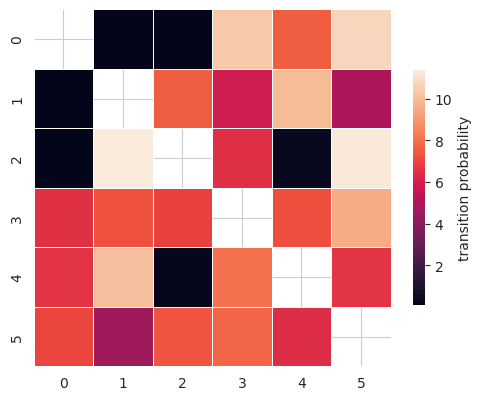

In [6]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

# plot energy matrix
mask = np.zeros_like(transition_prob)
mask[np.eye(n_states) == 1] = True
sns.heatmap(
    transition_prob,
    ax=ax,
    square=True,
    linewidth=0.5,
    cbar_kws={"label": "transition probability", "shrink": 0.5},
    mask=mask,
)

f.tight_layout()
plt.show()

In [7]:
transition_prob = np.zeros((n_states, n_states, n_states))
for i in np.arange(n_states):
    state_i_trs = np.where(labels == i)[0]
    if state_i_trs[-1] == (n_labels - 1):
        state_i_trs = state_i_trs[:-1]
    denominator = state_i_trs.shape[0]

    for j in np.arange(n_states):
        state_j_trs = np.where(labels[state_i_trs + 1] == j)[0]
        # state_j_trs = np.where(np.logical_and(labels[state_i_trs + 1] != i, labels[state_i_trs + 1] == j))[0]
        if len(state_j_trs) > 0 and state_j_trs[-1] == (n_labels - 1):
            state_j_trs = state_j_trs[:-1]

        for k in np.arange(n_states):
            state_k_trs = np.where(labels[state_j_trs + 1] == k)[0]
            # state_k_trs = np.where(np.logical_and(labels[state_j_trs + 1] != j, labels[state_j_trs + 1] == k))[0]
            if len(state_k_trs) > 0 and state_k_trs[-1] == (n_labels - 1):
                state_k_trs = state_k_trs[:-1]

            state_ijk_count = state_k_trs.shape[0]
            transition_prob[i, j, k] = np.round((state_ijk_count / denominator) * 100, 2)

transition_prob[:, 1, :]

array([[ 0.02,  0.03,  0.02,  0.02,  0.03,  0.03],
       [ 9.13, 13.83, 10.17, 11.77, 12.48, 14.23],
       [ 1.43,  2.23,  1.64,  1.84,  1.97,  2.26],
       [ 0.91,  1.45,  1.04,  1.18,  1.27,  1.46],
       [ 1.28,  1.98,  1.45,  1.62,  1.75,  2.01],
       [ 0.59,  0.89,  0.66,  0.74,  0.78,  0.92]])

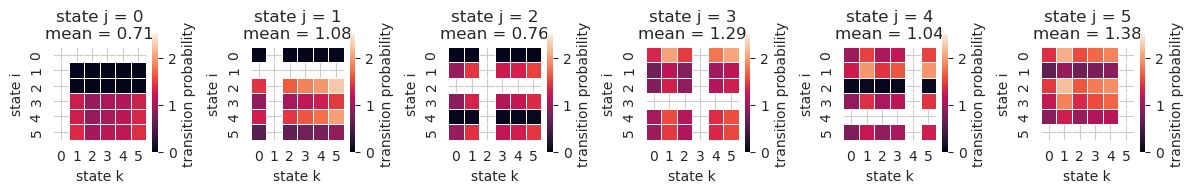

In [8]:
f, ax = plt.subplots(1, n_states, figsize=(n_states*2, 5))

# plot energy matrix
for i in np.arange(n_states):
    mask = np.zeros((n_states, n_states)).astype(bool)
    # mask[np.eye(n_states) == 1] = True
    # mask[0, :] = True
    # mask[:, 0] = True
    mask[i, :] = True
    mask[:, i] = True
    sns.heatmap(
        transition_prob[:, i, :], ax=ax[i], vmin=0, vmax=2.5,
        mask=mask,
        square=True, linewidth=0.5, cbar_kws={"label": "transition probability", "shrink": 0.25})
    ax[i].set_title('state j = {:}\nmean = {:.2f}'.format(i, transition_prob[:, i, :][~mask].mean()))
    ax[i].set_ylabel('state i')
    ax[i].set_xlabel('state k')

f.tight_layout()
plt.show()

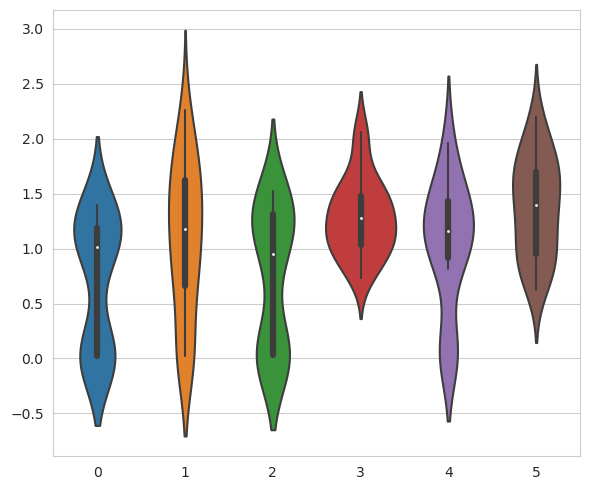

In [9]:
df = pd.DataFrame(columns=np.arange(n_states))

for i in np.arange(n_states):
    mask = np.zeros((n_states, n_states)).astype(bool)
    # mask[np.eye(n_states) == 1] = True
    # mask[0, :] = True
    # mask[:, 0] = True
    mask[i, :] = True
    mask[:, i] = True
    df.loc[:, i] = transition_prob[:, i, :][~mask]
    # df.loc[:, i] = transition_prob[:, i, :].flatten()

f, ax = plt.subplots(1, 1, figsize=(n_states, 5))
sns.violinplot(data=df, ax=ax)

f.tight_layout()
plt.show()